In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [21]:
def otsu_criteria_compute(img, th):
    """Compute the inter-class variance for t = th
    Inputs: 
        - img: the img numpy array
        - th: a certain given threshold
    Outputs:
        - the inter-class variance for t = th
    """
    # create the threshold image
    img_th = np.zeros(img.shape);
    img_th[img >= th] = 1;

    # compute the class probabilities
    w0 = np.count_nonzero(img_th==0)/img.size
    w1 = 1 - w0

    # if one class is empty
    if w0 == 0 or w1 == 0:
        return 0

    # compute the class means
    mean1 = np.mean(img[img >= th])
    mean2 = np.mean(img[img < th])

    return w0*w1*((mean1-mean2)**2)

def otsu_threshold(img):
    """Otsu thresholding implementation.
    
    Inputs:
        - img: the img numpy array with uint8 data type
    Outputs:
        - a threshold 
    """
    range_th = range(np.max(img)+1)
    results = [otsu_criteria_compute(img, th) for th in range_th]
    
    threshold = range_th[np.argmax(results)]
    return threshold

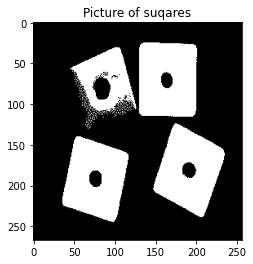

In [22]:
file_loc = "../../data/ass2/"
frame = np.loadtxt(file_loc+"squares.txt",delimiter=",").astype(np.uint8)
sigma_square= [otsu_criteria_compute(frame, th) for th in range(256)]
sigma_square = np.asarray(sigma_square)

otsu_t = otsu_threshold(frame)
otsu_res = np.zeros(frame.shape, dtype=np.uint8)

otsu_res[frame >= otsu_t] = 255

plt.imshow(otsu_res,cmap="gray")
plt.title("Picture of suqares")
plt.show()

## Otsu method result

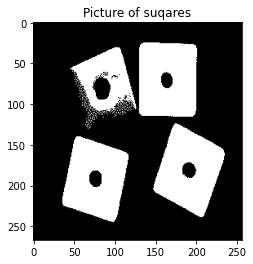

In [24]:
ret,th1 = cv2.threshold(frame,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
plt.imshow(th1,cmap="gray")
plt.title("Picture of suqares")
plt.show()

In [ ]:
x = np.arange(0, 256) 
plt.title("Otsu's Binarization ") 
plt.xlabel("t") 
plt.ylabel("$\sigma^{2}(t)$") 
plt.plot(x,sigma_square) 
plt.show()  

True

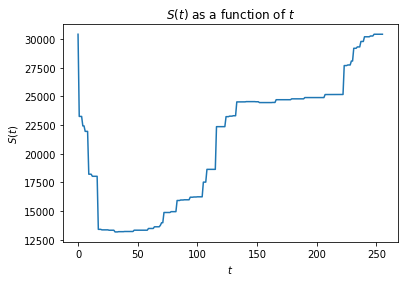

In [25]:
C = 256
range_th = range(C)
S_t = np.zeros(C, dtype=np.float64)

for t in range(C):
    mu_x = np.zeros(frame.shape, dtype=np.float64)

    # calculate means of class intensity
    class0 = frame[frame < t]
    if (class0.size == 0):
        # deal with empty slice
        mean0 = 0
    else:
        mean0 = np.mean(frame[frame < t])
    class1 = frame[frame >= t]
    if (class1.size == 0):
        # deal with empty slice
        mean1 = 0
    else:
        mean1 = np.mean(frame[frame >= t])

    # membership function calculation
    i,j = np.where(frame < t)
    mu_x[i, j] = 1/(1+np.abs(frame[i,j]-mean0)/C)
    i,j = np.where(frame >= t)
    mu_x[i, j] = 1/(1+np.abs(frame[i,j]-mean1)/C)

    # entropy
    S_x = np.zeros(frame.shape, dtype=np.float64)
    # deal with mu_x == 1
    mu_x[mu_x == 1.0] = 0.99999
    S_x = -(mu_x*np.log(mu_x)) - (1 - mu_x)*np.log(1-mu_x)
    S_t[t] = np.sum(S_x)

fuzzy_t = range_th[np.argmin(S_t)] 
fuzzy_res = np.zeros(frame.shape, dtype=np.uint8)
fuzzy_res[frame >= fuzzy_t] = 255

x = np.arange(0, 256) 
plt.title("$S(t)$ as a function of $t$ ") 
plt.xlabel("$t$") 
plt.ylabel("$S(t)$") 
plt.plot(x,S_t)
cv2.imwrite("../../result/ass2/fuzzy.png", fuzzy_res)



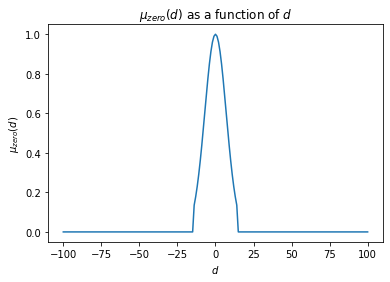

In [3]:
d_range = range(-100,101)
mu_zero = [truncated_gaussian(d) for d in d_range]

plt.title("$\mu_{zero}(d)$ as a function of $d$ ") 
plt.xlabel("$d$") 
plt.ylabel("$\mu_{zero}(d)$") 
plt.plot(d_range,mu_zero)
plt.savefig('mu_zero.png') 

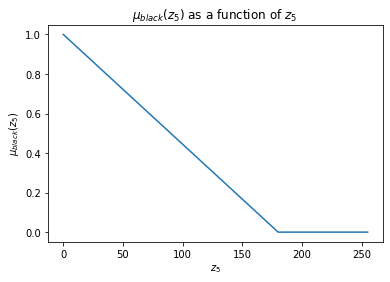

In [5]:
z_range = range(0, 256)
mu_black = [mu_black_function(z) for z in z_range]

plt.title("$\mu_{black}(z_{5})$ as a function of $z_{5}$ ") 
plt.xlabel("$z_{5}$") 
plt.ylabel("$\mu_{black}(z_{5})$") 
plt.plot(z_range,mu_black)

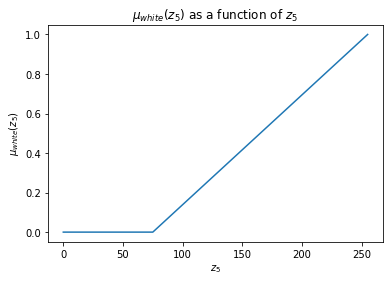

In [7]:
mu_white = [mu_white_function(z) for z in z_range]

plt.title("$\mu_{white}(z_{5})$ as a function of $z_{5}$ ") 
plt.xlabel("$z_{5}$") 
plt.ylabel("$\mu_{white}(z_{5})$") 
plt.plot(z_range,mu_white)

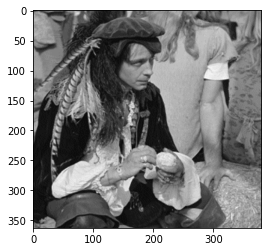

In [17]:
file_loc = "../../data/ass2/"
# int16 to deal with distance
frame = np.loadtxt(file_loc+"men.txt",delimiter=",").astype(np.int16)
plt.imshow(frame,cmap='gray')

In [35]:
def Inference(frame, m, n):
    distance = [frame[m+i][n+j] - frame[1][1] for i in range(-1,2) for j in range(-1,2)]
    distance.insert(0,0) # add pseudo neighbor to the beginning of distance list

    # distance
    mu_zero_d2 = truncated_gaussian(distance[2])
    mu_zero_d4 = truncated_gaussian(distance[4])
    mu_zero_d6 = truncated_gaussian(distance[6])
    mu_zero_d8 = truncated_gaussian(distance[8])

    # fuzzy sets for the output
    mu1 = [min(mu_zero_d2, mu_zero_d6, mu_white[z5]) for z5 in z_range]
    mu2 = [min(mu_zero_d6, mu_zero_d8, mu_white[z5]) for z5 in z_range]
    mu3 = [min(mu_zero_d4, mu_zero_d8, mu_white[z5]) for z5 in z_range]
    mu4 = [min(mu_zero_d2, mu_zero_d4, mu_white[z5]) for z5 in z_range]

    mu = max(mu1, mu2, mu3, mu4, mu_black)

    # centroid of gravity
    result = np.floor(sum(np.array(mu)*np.array(z_range))/sum(np.array(mu)))
    return result.astype(np.uint8)

In [15]:
distance = [frame[1+i][1+j] - frame[1][1] for i in range(-1,2) for j in range(-1,2)]

In [16]:
distance.insert(0,0) # add pseudo neighbor to the beginning of distance list

distance = [frame[m+i][n+j] - frame[1][1] for i in range(-1,2) for j in range(-1,2)]
distance.insert(0,0) # add pseudo neighbor to the beginning of distance list

# distance
mu_zero_d2 = truncated_gaussian(distance[2])
mu_zero_d4 = truncated_gaussian(distance[4])
mu_zero_d6 = truncated_gaussian(distance[6])
mu_zero_d8 = truncated_gaussian(distance[8])

# rule 1
mu1 = [min(mu_zero_d2, mu_zero_d6, mu_white[z5]) for z5 in z_range]
# rule 2
mu2 = [min(mu_zero_d6, mu_zero_d8, mu_white[z5]) for z5 in z_range]
# rule 3
mu3 = [min(mu_zero_d4, mu_zero_d8, mu_white[z5]) for z5 in z_range]
# rule 4
mu4 = [min(mu_zero_d2, mu_zero_d4, mu_white[z5]) for z5 in z_range]
# rule 5
mu = max(mu1, mu2, mu3, mu4, mu_black)

# centroid of gravity
result = np.floor(sum(np.array(mu)*np.array(z_range))/sum(np.array(mu)))
result.astype(np.uint8)

59

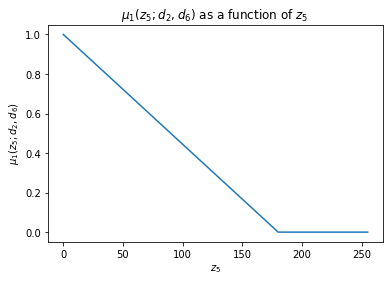

In [19]:
plt.title("$\mu_{1}(z_{5}; d_{2}, d_{6})$ as a function of $z_{5}$ ") 
plt.xlabel("$z_{5}$") 
plt.ylabel("$\mu_{1}(z_{5}; d_{2}, d_{6})$") 
plt.plot(z_range, mu)